In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import seaborn as sns

# Data Preprocessing

In [2]:
df = pd.read_csv('./archive/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
print(df['Class'].value_counts())
print('----------------------------------------------')
print(df['Class'].value_counts(normalize=True) * 100)
df = df.drop('Time', axis=1)
df_pos = df[df['Class'] == 0]
df_pos = df_pos.sample(frac=1)
df_neg = df[df['Class'] == 1]
df_neg = df_neg.sample(frac=1)

0    284315
1       492
Name: Class, dtype: int64
----------------------------------------------
0    99.827251
1     0.172749
Name: Class, dtype: float64


## Data Inbalance, Sample Data

In [4]:
batch_size = 64
DATA_SPLIT_RATE = 0.8
COPY = int(len(df_pos) / len(df_neg))

pos_split = int(len(df_pos) * DATA_SPLIT_RATE // 1)
train_pos = df_pos[:pos_split]
test_pos = df_pos[pos_split:]

neg_split = int(len(df_neg) * DATA_SPLIT_RATE // 1)
train_neg = df_neg[:neg_split]
test_neg = df_neg[neg_split:]

train_neg_ = train_neg.copy()

for i in range(COPY):
    train_neg = pd.concat([train_neg, train_neg_], ignore_index=True)

454606


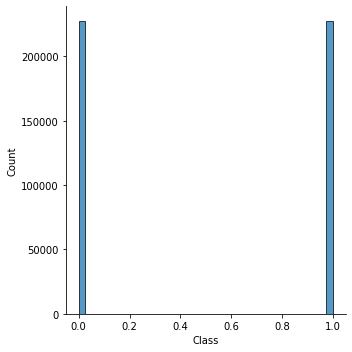

In [5]:
df_all = pd.concat([train_pos, train_neg], ignore_index=True)
df_all = df_all.sample(frac=1)
df_all.reset_index(drop=True, inplace=True)
sns.displot(df_all['Class'])
print(len(df_all))
df_all_ = df_all.drop('Class', axis=1)

In [6]:
train = torch.tensor(df_all_.values.astype(np.float32))
target = torch.tensor(df_all['Class'].values.astype(np.float32))
train_set = torch.utils.data.TensorDataset(train, target)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

# Build Model

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(29, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )
        self.Decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 29),
        )
    def forward(self, inputs):
        codes = self.Encoder(inputs)
        decoded = self.Decoder(codes)
        return codes, decoded

In [12]:
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.FC = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        x = self.FC(x)
        return x

## Optimizer and loss function

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)

Cmodel = Classification().to(device)

LR = 3e-4
Epoch = 10
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training AutoEncoder

In [9]:
from tqdm import tqdm
for i in range(Epoch):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        codes, decoded = model(inputs)
        
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()
    # Show progress
    print('[{}/{}] Loss:'.format(i+1, Epoch), loss.item())
# Save
torch.save(model, 'autoencoder.pth')

100%|██████████| 7104/7104 [00:29<00:00, 240.80it/s]


[1/10] Loss: 1.0394210815429688


100%|██████████| 7104/7104 [00:29<00:00, 243.69it/s]


[2/10] Loss: 0.5862821936607361


100%|██████████| 7104/7104 [00:28<00:00, 245.26it/s]


[3/10] Loss: 0.4080249071121216


100%|██████████| 7104/7104 [00:28<00:00, 247.60it/s]


[4/10] Loss: 0.3291270136833191


100%|██████████| 7104/7104 [00:28<00:00, 247.42it/s]


[5/10] Loss: 0.2935461401939392


100%|██████████| 7104/7104 [00:28<00:00, 248.42it/s]


[6/10] Loss: 0.4079771935939789


100%|██████████| 7104/7104 [00:28<00:00, 247.75it/s]


[7/10] Loss: 0.7964762449264526


100%|██████████| 7104/7104 [00:29<00:00, 243.53it/s]


[8/10] Loss: 0.8698421120643616


100%|██████████| 7104/7104 [00:28<00:00, 244.99it/s]


[9/10] Loss: 0.25812914967536926


100%|██████████| 7104/7104 [00:28<00:00, 246.57it/s]

[10/10] Loss: 0.1578819304704666


# Testing AutoEncoder

In [10]:
test_set = pd.concat([test_pos, test_neg], ignore_index=True)
test_set = test_set.sample(frac=1)
test_set.reset_index(drop=True, inplace=True)
test_ = test_set.drop('Class', axis=1)
test_ = torch.tensor(test_.values.astype(np.float32))
target = test_set['Class']
target = torch.tensor(target.values.astype(np.float32))

test = torch.utils.data.TensorDataset(test_, target)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [11]:
model.eval()
total = 0
test_loss = 0.0
with torch.no_grad():
    for idx, data in enumerate(tqdm(test_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        codes, decoded = model(inputs)
        loss = criterion(inputs, decoded)
        test_loss += loss.item()
        total += labels.size(0)
    print('Testing loss: %.3f'%(test_loss / total))

100%|██████████| 891/891 [00:00<00:00, 1090.92it/s]

Testing loss: 0.003
